# Vortex near cylinder

In [25]:
using Pkg
Pkg.activate("/Users/beckers/Google Drive/Academic/UCLA/CodingInProgress/ViscousFlow.jl");
using ViscousFlow
using Plots
using LinearAlgebra
using DifferentialEquations

# pyplot()
clibrary(:colorbrewer)
default(grid = false)

In [17]:
mutable struct Vortex
    x::Real
    y::Real
    Γ::Real
end

In [18]:
function advect!(p::Vortex, u::Real, v::Real , Δt::Float64) where T
#     print("current position: $(p.x)\n")
#     print("velocity: $(v)\n")
#     print("updated position: $(p.x .+ v.*Δt)\n")
    p.x += u*Δt
    p.y += v*Δt
end

advect! (generic function with 1 method)

### Eulerian grid

In [19]:
nx = 128; ny = 128;
Lx = 2.0;
dx = Lx/(nx-2);
display(dx)
w = Nodes(Dual,(nx,ny));
q = Edges(Primal,(nx,ny));
ψ = Nodes(Dual,w);
# qx = Nodes(Dual,(nx,ny))
# qy = Nodes(Dual,(nx,ny))
L = plan_laplacian(size(w),with_inverse=true)

0.015873015873015872

Discrete Laplacian (and inverse) on a (nx = 128, ny = 128) grid with spacing 1.0

### Body

In [20]:
n = 196

R = 0.5
body = Ellipse(R,R,n)

# Find the minimum arc length
ds = minimum(Bodies.dlength(body))

# Move the circle
xc = 1.0; yc = 1.0
T = RigidTransform((xc,yc),0.0)
T(body)

X = VectorData(body.x,body.y)
f = ScalarData(X);
ψb = ScalarData(X);

oB = zeros(size(f))
oB .= 1;

### Problem parameters

In [21]:
vortex_1 = Vortex(1.0,0.25,1.0)

vortices = Array{Vortex,1}()
push!(vortices,vortex_1)

# Start time
tloc = 0.0

# The desired streamfunction on the circle surface
ψb .= 1

# The desired circulation about the circle
Γ0 = 0;

In [26]:
ψb

196 points of scalar-valued data
196-element Array{Float64,1}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮  
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [22]:
function rhs(vortices_loc::VectorData,vortices_Γ::ScalarData,t::Float64)

    L⁻¹(w::T) where {T} = L\w;
    
    # Regularize vorticity to grid
    Hw = Regularize(vortices_loc,dx;ddftype=Fields.M4prime,issymmetric=true)
    Hw(w,vortices_Γ)
    
    # Solve potential flow
    E = Regularize(X,dx;issymmetric=true);
    Hmat,Emat = RegularizationMatrix(E,f,w);
    PS = SaddleSystem((w,f),(L⁻¹,Hmat,Emat),issymmetric=true,isposdef=true);
    S = Matrix(PS.S);
    S₀ = transpose(oB)*(S\oB);
    T = S - oB*transpose(oB)/S₀;
    f .= S\(T*(S\(Emat*(L\w).+ψb)) .+ Γ0*oB/S₀);
    ψ₀ = -1/S₀*(Γ0 - transpose(oB)*(S\(Emat*(L\w).+ψb)));
    ψ .= -(L\(Hmat*f))-(L\(w)) .+ ψ₀; 
    
    # Calculate velocity field
    q .= curl(ψ)/(dx);
    
    
    vel = VectorData(vortices_Γ)
    q_nodes = Nodes(Dual,(nx,ny))
    
    # Interpolate to nodes before interpolating to vortex point
    Fields.interpolate!((q_nodes),q.u);
    Hw(vel.u,q_nodes)
    Fields.interpolate!((q_nodes),q.v);
    Hw(vel.v,q_nodes)
    
    return vel
    
end 

rhs (generic function with 1 method)

### Time marching

In [23]:
tf = 0.1
tspan = (0.0,tf);#0.25
vortices_loc = VectorData([vortex.x for vortex in vortices],[vortex.y for vortex in vortices])
vortices_Γ = ScalarData([vortex.Γ for vortex in vortices])
# u0 = [vortices_loc.u vortices_loc.v]
prob = ODEProblem(rhs,vortices_loc,tspan,vortices_Γ)

ODEProblem with uType VectorData{1} and tType Float64. In-place: false
timespan: (0.0, 0.1)
u0: [1.0, 0.25]

In [24]:
sol = @time solve(prob,dt=0.1,RK4(),dense=false)

  2.733137 seconds (36.12 M allocations: 1.056 GiB, 7.16% gc time)


retcode: Success
Interpolation: 1st order linear
t: 2-element Array{Float64,1}:
 0.0
 0.1
u: 2-element Array{VectorData{1},1}:
 [1.0, 0.25]         
 [0.982361, 0.250206]

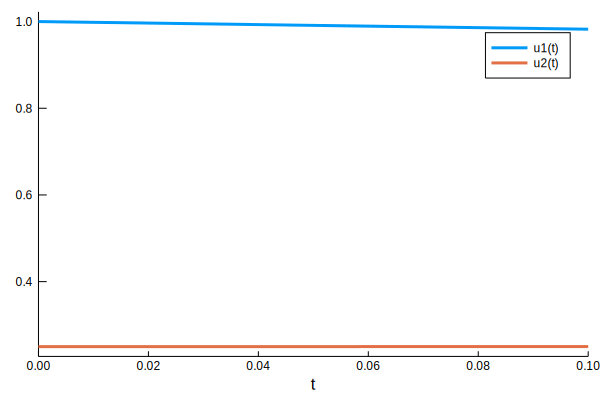

In [10]:
plot(sol)
# savefig("vortex_pair_rotating_goza_coordinates.pdf")

### Plot results

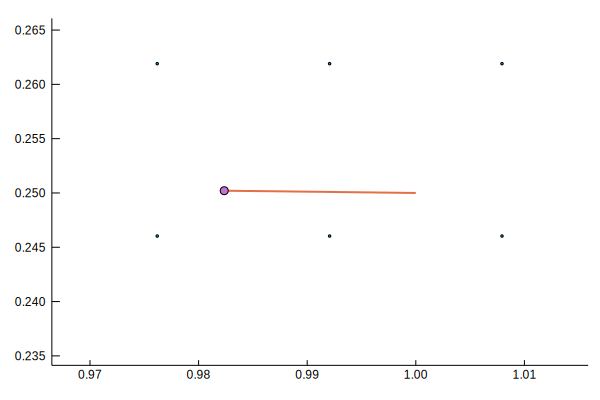

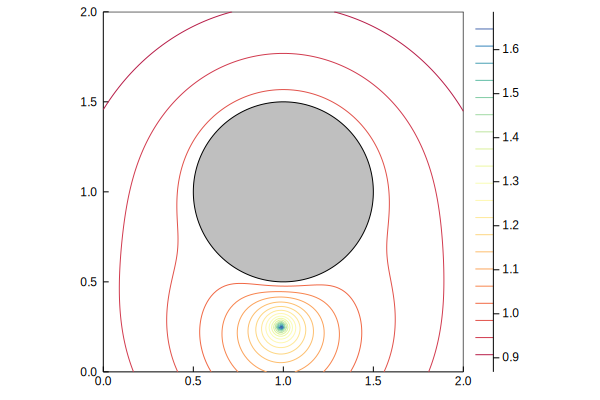

In [11]:
xg,yg = coordinates(ψ,dx=dx)
coord = [(x,y) for x in xg, y in yg]

p1 = scatter(first.(coord)[:],last.(coord)[:],ratio=:equal,markersize=1)
plot!(sol,vars=(1,2),lw=2)
plot!(body,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)
scatter!([sol[end][1]],[sol[end][2]])
xlims!(minimum(sol[1,:])-1*dx,maximum(sol[1,:])+1*dx)
ylims!(minimum(sol[2,:])-1*dx,maximum(sol[2,:])+1*dx)

p4 = plot(sol,vars=(1,2),lw=2,color=:black)
plot!(xg,yg,ψ,levels=20);
plot!(body,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)
plot!(xlims=(0,Lx),ylims=(0,Lx))
# savefig("vortex_pair_rotating_goza.pdf")

display(p1)

display(p4)

### Analytical results

In [12]:
d = sqrt((vortices[1].x-vortices[2].x)^2 + (vortices[1].y-vortices[2].y)^2)

BoundsError: BoundsError: attempt to access 1-element Array{Vortex,1} at index [2]

#### Opposite circulation

In [109]:
U = vortices[1].Γ/(4π*d)
println("Analytical self-induced velocity = $U")
println("Analytical distance traveled = $(U*tf)")
println("Numerical distance traveled = $(sol[1][1]-sol[end][1])")

Analytical self-induced velocity = 0.15915494309189535
Analytical distance traveled = 0.784633869443044
Numerical distance traveled = 0.002885700269819935


#### Equal circulation

In [111]:
T = 2π^2*d^2/vortices[1].Γ
println("Analytical period = $T")

Analytical period = 4.934802200544679


In [70]:
0.050550532375431945/1.5915494309189535

0.031761836229142

In [47]:
typeof(vortices_loc)

VectorData{1}

In [59]:
?ODEProblem

search: ODEProblem RODEProblem SplitODEProblem DynamicalODEProblem



```julia
struct ODEProblem{uType, tType, isinplace, P, F, K, PT} <: DiffEqBase.AbstractODEProblem{uType,tType,isinplace}
```

Defines an ODE problem.

# Fields

  * `f`

    The function in the ODE.
  * `u0`

    The initial condition.
  * `tspan`

    The timespan for the problem.
  * `p`

    The parameter values of the ODE function.
  * `kwargs`

    A callback to be applied to every solver which uses the problem.
  * `problem_type`

    TODO

---

```
ODEProblem(f::ODEFunction,u0,tspan,p=NullParameters(),callback=CallbackSet())
```

Define an ODE problem from a [`ODEFunction`](@ref).
